<a href="https://colab.research.google.com/github/DoHyung08/RL/blob/main/0310%20bandit/bandit_my.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 슬롯머신 정복하기


### 슬롯머신 환경 구현하기

각각의 밴딧 $i = 1, \cdots, n$에 대해, 먼저 랜덤하게 실제 가치 $\mu_{i} \sim N(0, 1)$를 평균 0 분산 1인 표준정규분포에서 추출해 정해줍니다. 그리고 $i$번 째 밴딧을 고를 경우, 받을 수 있는 보상은 다음과 같이 정해줍니다:
$$
r_{t} = \mu_{i} + \varepsilon \quad \text{where} \quad \varepsilon \sim N(0, 1)
$$
즉, $i$번 째 밴딧을 골랐을 때의 보상은, 그 밴딧의 실제 가치 $\mu_{i}$에 랜덤한 표준 정규 노이즈 $\varepsilon \sim N(0, 1)$을 더한 것입니다.

In [65]:
!pip install gymnasium[classic-control]

표준 정규분포를 뽑아 히스토그램으로 나타내었다. 0 부분에 값이 밀집된 것이 보인다.

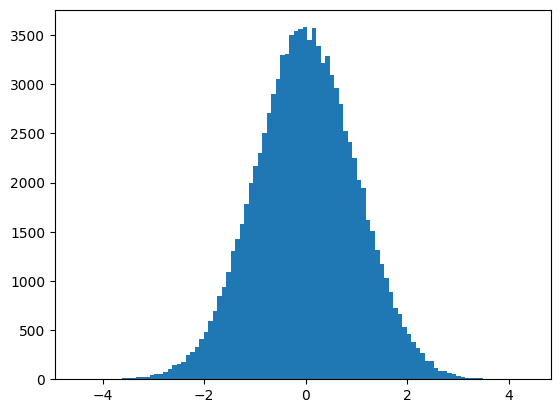

In [3]:
import numpy as np
import matplotlib.pyplot as plt


plt.hist(np.random.normal(0,1,100000), bins= 100)

plt.show()

슬롯머신 환경 구현.
슬롯머신 개수, 그를통한 행동 공간을 초기화시키고
상태는 없으므로 빈 리스트로 초기화시킨다.
슬롯머신을 땡긴다고 슬롯머신의 상태가 변하는 것이 아니기 때문이다.

In [100]:
import numpy as np
import gymnasium as gym

class BanditEnv(gym.Env):
    def __init__(self, num_bandits):
      self.num_bandits = num_bandits#슬롯머신의 개수
      self.action_space = list(range(num_bandits))#취할 수 있는 행동은 모든 슬롯머신과 같다.
      self.observation_space = [0]#상태는 없으므로 아무런 리스트

    def reset(self):
      self.mean = [8, 9, 7.5, 7, 8.5, 7, 6, 7.5, 8, 8.5]#초기 확률을 정한다. 2번째 슬롯머신이 가장 좋은 것이다.
      #self.mean = np.random.normal(size = self.num_bandits) * 10

      return 0

    def step(self, action):
      state = 0#상태가 없다. 즉 상태가 안바뀐다.
      mean = self.mean[action]
      reward = mean + np.random.normal()#보상에 노이즈를 준다.
      done = False#항상 끝나지 않음.
      return state, reward, done, []


###테스트

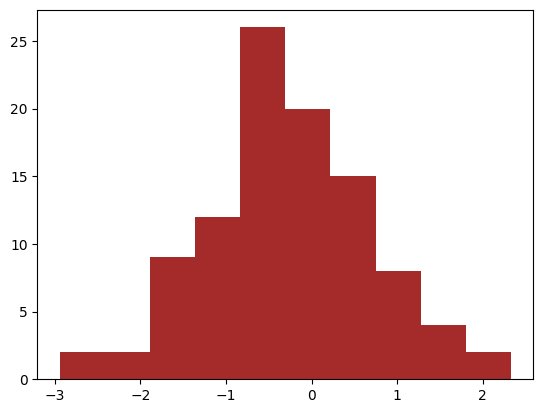

-26.96162485071247


In [59]:
env = BanditEnv(10)
state = env.reset()

rewards = []
total_reward = 0

for i in range(100):
  action = 0
  state, reward, done, _ = env.step(action)
  rewards.append(reward)
  total_reward += reward

plt.hist(rewards, color='brown')
plt.show()
print(total_reward)


##내 정책 : 가치를 가중치로 하여 랜덤 선택
뒤로 갈수록 활용만 일어난다는 단점은 해결하지 못함

시작 가치가 매우 비슷하거나 작은 값으로 평준화 되어 있는 경우 가치가 거의 수정되지 못하고 완전 랜덤 선택이 일어날 수 있는 단점이 있다.

비슷한 원리를 사용한 UCB 방법이란 것이 존재한다.
이것또한 원리를 연구해 내 알고리즘과 접목시켜 보아야겠다.

In [140]:
import random
import numpy as np
import gymnasium as gym

class BanditEnv(gym.Env):
    def __init__(self, num_bandits):
      self.num_bandits = num_bandits#슬롯머신의 개수
      self.action_space = list(range(num_bandits))#취할 수 있는 행동은 모든 슬롯머신과 같다.
      self.observation_space = [0]#상태는 없으므로 아무런 리스트

    def reset(self):
      self.mean = [8, 9, 7.5, 7, 8.5, 7, 6, 7.5, 8, 8.5]
      #self.mean = np.random.normal(size = self.num_bandits) * 10

      return 0

    def step(self, action):
      state = 0#상태가 없다. 즉 상태가 안바뀐다.
      mean = self.mean[action]
      reward = mean + np.random.normal()
      done = False#항상 끝나지 않음.
      return state, reward, done, []


In [141]:
class pol:
  def __init__(self, num_bandits):
    self.num_bandits = num_bandits #슬롯머신 개수 저장
    self.values = [1/num_bandits for m in range(num_bandits)]
    self.action_space = list(range(0, num_bandits))

  def __call__(self, state, pre_reward, pre_action):

    action = random.choices(range(0,self.num_bandits),weights = self.values)#가치를 가중치로 하여 랜덤 선택


    if(pre_reward > 7):
      self.values[pre_action] *= 1.15 #보상에 따라 가치 변화. 양수여야하므로 곱하기와 나누기
    else:
      self.values[pre_action] /= 1.15


    return action

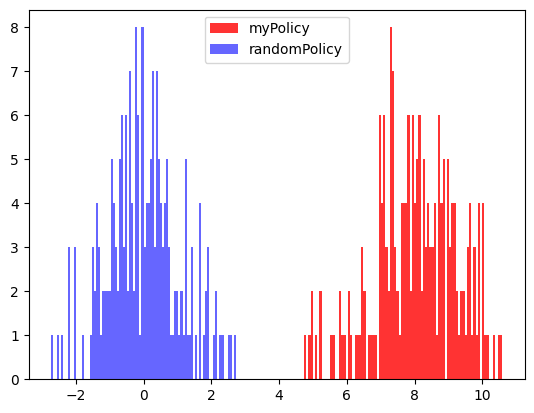

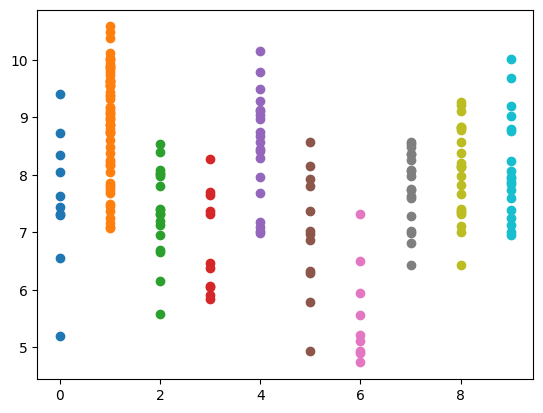

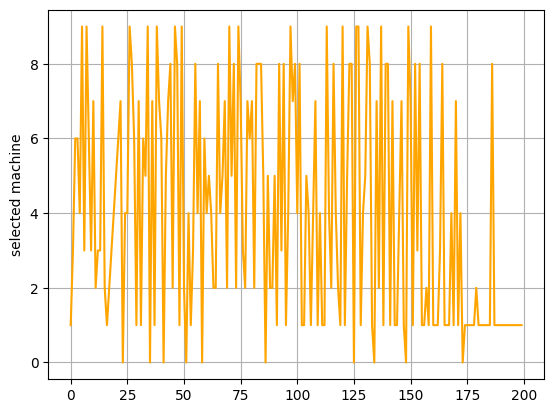

total reward : 1603.9265662051446


In [142]:
bandingMachine = 10


env = BanditEnv(bandingMachine)

state = env.reset()
reward = 0
rewards = []

total_reward = 0
agent = pol(10)

action = 0
reaptt = 200
history = {i: [] for i in range(env.num_bandits)}
history_plot = []

for i in range(reaptt):
  pre_action = action
  action = agent(state, reward, pre_action)[0]

  state, reward, done, _ = env.step(action)

  rewards.append(reward)
  total_reward += reward

  history[action].append(reward)

  history_plot.append(action)


rewards = np.array(rewards).reshape(-1)
#print(rewards.shape)



plt.hist(rewards, color='red', bins = bandingMachine * 9, label='myPolicy', alpha = 0.8)#랜덤하게 뽑은것과, 가중치를 이용해 뽑은것의 히스토그램
plt.hist(np.random.normal(0,1,reaptt), color='blue', bins = bandingMachine * 9, label='randomPolicy', alpha = 0.6)
plt.legend()
plt.show()




import matplotlib.pyplot as plt
for machine in range(env.num_bandits):
  plt.scatter([machine]*len(history[machine]), history[machine])#각 머신의 선택 횟수를 산점도로 표현
plt.show()

plt.plot(history_plot, color='orange')#선택된 머신을 순서대로 플롯으로 표현
plt.ylabel("selected machine")

plt.grid(True)
plt.show()

print(f"total reward : {total_reward}")#보상 총합 표현. 평균을 사용한 선택과 큰 차이는 없었다.(머신개수=10, 반복횟수=20)

##평균값으로 정책 설정
평균값을 히스토리에 저장하지 않고 수정치 공식을 사용하여 변경해주었다.

Q_(k+1) = Q_K + 1/k (R_k - Q_k).
이때 1/k (R_k - Q_k)는 수정치로 표현된다.

In [129]:
import gymnasium as gym
import numpy as np


class BanditEnv(gym.Env):
    def __init__(self, num_bandits):
        self.num_bandits = num_bandits # 슬롯머신의 갯수
        self.action_space = list(range(num_bandits)) # 행동은 가능한 모든 슬롯머신
        self.observation_space = [0] # 상태는 의미 없음

    def reset(self):
        # 슬롯머신의 평균 보상의 크기를 미리 결정하는 코드
        # 각 슬롯머신에 대해, 랜덤한 평균 보상의 크기를 결정해 줌.
        # self.mean = np.random.normal(size=self.num_bandits) * 10

        # 아래는 항상 같은 크기의 보상을 정해둔 코드의 예시
        self.mean = [8, 9, 7.5, 7, 8.5, 7, 6, 7.5, 8, 8.5]
        return 0 # 상태 전환 없음. 의미 없음.

    def step(self, action):
        state = 0
        mean = self.mean[action] # 정해둔 평균값에서 선택한 슬롯머신에 대한 값 확인
        reward = mean + np.random.normal() # 보상은 그 슬롯머신의 평균값 + 랜덤한 노이즈
        done = False
        return state, reward, done, {}


In [130]:
class MyPolicy:
  def __init__(self, num_bandits):
    self.num_bandits = num_bandits # 슬롯머신 개수 저장
    # 이 아래에 본인이 더 저장하고 싶은 정보 정의 가능!
    self.q = [100 for machine in range(num_bandits)]
    self.n = {i:0 for i in range(env.num_bandits)}#슬롯머신 몇번 땡겼는지



  def __call__(self, state):
    action = np.argmax(self.q)
    return action

In [131]:
env = BanditEnv(10)
state = env.reset()
agent = MyPolicy(10)

# 그동안의 선택 정보를 저장


total_reward = 0
for t in range(20):
  action = agent(state)
  print(f"action: {action}")

  state, reward, done, _ = env.step(action)

  # 기록 저장

  agent.q[action] += (reward - agent.q[action]) / max(1, agent.n[action])#평균 업데이트

  agent.n[action] += 1

  total_reward += reward

print(f"Total Reward: {total_reward}")

# 기록 플롯
import matplotlib.pyplot as plt
#for machine in range(env.num_bandits):
  #plt.scatter([machine]*(len(history[machine])-1), history[machine][1:])


action: 0
action: 1
action: 2
action: 3
action: 4
action: 5
action: 6
action: 7
action: 8
action: 9
action: 1
action: 4
action: 1
action: 1
action: 1
action: 1
action: 1
action: 1
action: 1
action: 1
Total Reward: 164.6976701347692


## epsilon greedy algorithm 이용

뒤로 갈수록 같은 것만 선택, 즉 exploit하는 문제 발생
후반부 상황에서도 일정한 확률로 exploration

In [149]:
import gymnasium as gym
import numpy as np


class BanditEnv(gym.Env):
    def __init__(self, num_bandits):
        self.num_bandits = num_bandits # 슬롯머신의 갯수
        self.action_space = list(range(num_bandits)) # 행동은 가능한 모든 슬롯머신
        self.observation_space = [0] # 상태는 의미 없음

    def reset(self):
        # 슬롯머신의 평균 보상의 크기를 미리 결정하는 코드
        # 각 슬롯머신에 대해, 랜덤한 평균 보상의 크기를 결정해 줌.
        # self.mean = np.random.normal(size=self.num_bandits) * 10

        # 아래는 항상 같은 크기의 보상을 정해둔 코드의 예시
        self.mean = [8, 9, 7.5, 7, 8.5, 7, 6, 7.5, 8, 8.5]
        return 0 # 상태 전환 없음. 의미 없음.

    def step(self, action):
        state = 0
        mean = self.mean[action] # 정해둔 평균값에서 선택한 슬롯머신에 대한 값 확인
        reward = mean + np.random.normal() # 보상은 그 슬롯머신의 평균값 + 랜덤한 노이즈
        done = False
        return state, reward, done, {}


In [150]:
class MyPolicy:
  def __init__(self, num_bandits):
    self.num_bandits = num_bandits # 슬롯머신 개수 저장
    # 이 아래에 본인이 더 저장하고 싶은 정보 정의 가능!
    self.q = [100 for machine in range(num_bandits)]
    self.n = {i:0 for i in range(env.num_bandits)}#슬롯머신 몇번 땡겼는지

    # 예시
    # self.q = [8, 6, 7, 7, 6, ..., 2] -> 슬롯머신마다 계산한 평균값

  def __call__(self, state):
    action = np.argmax(self.q)
    return action

In [154]:
env = BanditEnv(10)
state = env.reset()
agent = MyPolicy(10)

# 그동안의 선택 정보를 저장


total_reward = 0
for t in range(20):
  alpha = random.randint(0,10)
  if alpha==5:
    action = random.randint(0,env.num_bandits)
  else:
    action = agent(state)

  print(f"action: {action}")

  state, reward, done, _ = env.step(action)

  # 기록 저장

  agent.q[action] += (reward - agent.q[action]) / max(1, agent.n[action])#평균 업데이트

  agent.n[action] += 1

  total_reward += reward

print(f"Total Reward: {total_reward}")

# 기록 플롯
import matplotlib.pyplot as plt
#for machine in range(env.num_bandits):
  #plt.scatter([machine]*(len(history[machine])-1), history[machine][1:])


action: 0
action: 1
action: 2
action: 3
action: 4
action: 5
action: 6
action: 7
action: 8
action: 9
action: 1
action: 1
action: 1
action: 1
action: 1
action: 1
action: 1
action: 1
action: 1
action: 1
Total Reward: 161.13174451048639
